In this notebook, we will look into effect of bacthsize on learning through BCM rule (QBCM and ReLU)

In [21]:
%reset -f
%reload_ext autoreload

# %load BCM_running.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
%matplotlib inline
from learning_plasticity import data_loader
from learning_plasticity import BCM_cl
from learning_plasticity import BCM_fully_connect_cl as BCM
# Reset tf.app.flags.FLAGS
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()

from tensorflow.python.framework import ops
ops.reset_default_graph()


Here, we will modify on top of the direct implementation of BCM rule to study the batch effect.

In [22]:
data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = False, iffigure = False)

array([[ 3.54441164,  0.26206108,  0.20690492,  4.0019313 ]])

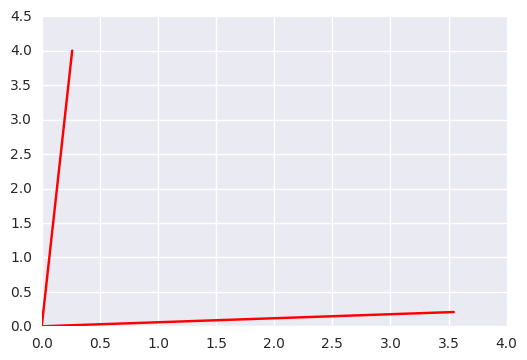

In [23]:
#data_loaded = np.load('data.npz')
#data, data_w = data_loaded['data'], data_loaded['data_w']
import pdb

n_output = 2
eta = 0.0005
decay = 0.01
p = 2
tau = 200
epoch = 200
seed = 0
batch = 1

sample_size = data.shape[0]
dim_x = data.shape[1]
# Give input place holder

input_value = tf.placeholder(tf.float64, [batch, dim_x])
obj_input = tf.placeholder(tf.float64, [sample_size, dim_x])

# Varaible
r_gen = np.random.RandomState(seed)
w = tf.Variable(r_gen.randn(dim_x, n_output), dtype=tf.float64)
# w = tf.Variable(tf.zeros([dim_x, n_output])+0.2)
# w = tf.Variable(tf.random_normal([dim_x, n_output]))
threshold = tf.Variable(tf.zeros([1, n_output], dtype=tf.float64), dtype=tf.float64)

### Computation steps
# Compute output with ReLU
net_input = tf.matmul(input_value, w)
output_value = tf.nn.relu(net_input)

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
delta_w = eta / batch * tf.matmul(input_value, tf.mul(output_value, out_thre_diff), transpose_a = True)- eta * decay * w
new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.cast(tf.exp(-1/tau), tf.float64)
new_thres = threshold * h + tf.pow(tf.reduce_mean(output_value, 0), p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.square(obj2)/4

# Train the model

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

w_track = []
y_track = []
thres_track = []
for i in range(epoch):
    tf.random_shuffle(data)
    for j in range(int(np.floor(data.shape[0]/batch))):
#        print(data[j,:])
        sess.run([update_w, update_thres], feed_dict = {input_value: data[j*batch:(j+1)*batch,:].reshape(batch,dim_x)})
        #sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,2)})
        #sess.run(obj, feed_dict = {obj_input: data})
        w_track.append(sess.run(w).reshape(1,4))
        thres_track.append(sess.run(threshold))

# Plot the final weight
final_w = sess.run(w).reshape(1,4)
#plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'k')
#plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'k')
trained_w = np.vstack(w_track)

g = plt.gca()
plt.plot([0, final_w[0][0]], [0, final_w[0][2]], 'r')
plt.plot([0, final_w[0][1]], [0, final_w[0][3]], 'r')
final_w

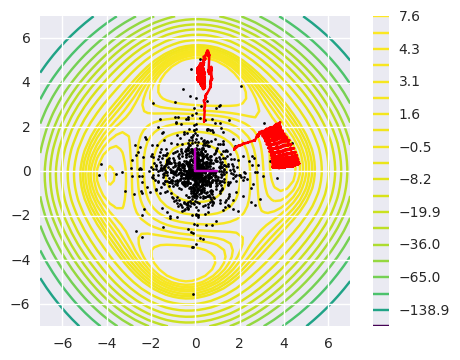

In [24]:
import seaborn as sns

#data_loaded = np.load('data.npz')
#data, data_w = data_loaded['data'], data_loaded['data_w']
sample_size = data.shape[0]
dim_x = 2
w_min = -7
w_max = 7
reso = 50

w = np.linspace(w_min, w_max, reso)
wx, wy = np.meshgrid(w, w)
w = np.vstack((wx.ravel(), wy.ravel()))

# input placeholder
obj_input = tf.placeholder(tf.float64, [sample_size, dim_x])
w_ph = tf.placeholder(tf.float64,w.shape)

# Operation
def obj(X, w, obj_type='QBCM', nonlinear='Sigmoid'):
    c = tf.matmul(X, w)
    if nonlinear == 'Sigmoid':
        c = tf.Sigmoid(c)
    elif nonlinear == 'ReLU':
        c = tf.nn.relu(c)

    obj = 0

    if obj_type == 'QBCM':
        obj1 = tf.reduce_mean(tf.pow(c, 3), 0)
        #obj1 = tf.pow(c, 3)
        obj2 = tf.reduce_mean(tf.pow(c, 2), 0)
        obj = obj1 / 3 - tf.square(obj2) / 4
    # obj = - obj2/2
    elif obj_type == 'kurtosis':
        obj1 = tf.reduce_mean(tf.pow(c, 4), 0)
        obj2 = tf.reduce_mean(tf.pow(c, 2), 0)
        obj = obj1 - tf.square(obj2)* 3
    elif obj_type == 'skewness':
        obj1 = tf.reduce_mean(tf.pow(c, 3), 0)
        obj2 = tf.reduce_mean(tf.pow(c, 2), 0)
        obj = np.divide(obj1, obj2 ** 1.5)
    else:
        print('Wrong objective function')
    
    return obj


obj_choice = ['QBCM', 'kurtosis']
nonlinear_choice = ['Relu', 'Sigmoid', 'None']

# parameter passed through para
dim_x = 2
n_output = 2
eta = 0.00005
decay = 0.01
p = 2
tau = 200
epoch = 1
seed = 0

obj_type = 'QBCM'
nonlinear = 'ReLU'

obj_landscape = obj(obj_input, w_ph, obj_type=obj_type, nonlinear=nonlinear)
obj_reshape = tf.reshape(obj_landscape, wx.shape)
sess = tf.Session()
final_obj = sess.run(obj_reshape, feed_dict = {obj_input: data, w_ph: w})
title_set = [obj_type, nonlinear]

nbins = 20
levels = np.percentile(final_obj, np.linspace(0, 100, nbins))

fig, ax = plt.subplots(1,1)
with sns.axes_style('white'):
    g = ax

c = g.contour(wx, wy, final_obj, levels=levels, zorder=-10,cmap=plt.cm.get_cmap('viridis'))
g.plot(data[:, 0], data[:, 1], '.k', ms=4)
g.set_aspect(1)

plt.grid('on')
plt.colorbar(c, ax=g)

plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'm')
plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'm')
plt.plot(trained_w[:,0], trained_w[:,2], 'r')
plt.plot(trained_w[:,1], trained_w[:,3], 'r')

